In [1]:
import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd

from pprint import pprint
from skimage import io
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [2]:
!ls rsna-pneumonia-detection-challenge

GCP Credits Request Link - RSNA.txt stage_2_test_images
stage_2_detailed_class_info.csv     stage_2_train_images
stage_2_sample_submission.csv       stage_2_train_labels.csv


# Load pneumonia images, bounding boxs and detail infos

csv file -- stage_2_train_labels.csv
* If a patient got diagnoised with multiple pneumonia, rows of bounding boxs of different pneumonia locations with same patientId will appear.
* If a patient has no pneumonia, csv contains a single row with nan for bounding boxs.

csv file -- stage_2_detailed_class_info.csv

* patientId with the final diagnoised varies between Normal, Lung Opacity, and No Lung Opacity / Not Normal.

In [3]:
dir_dicom = os.path.join(os.getcwd(), 'rsna-pneumonia-detection-challenge')
dicoms_training = os.path.join(dir_dicom, 'stage_2_train_images')

In [4]:
df = pd.read_csv(os.path.join(dir_dicom, 'stage_2_train_labels.csv')).fillna(0)
df_detail = pd.read_csv(os.path.join(dir_dicom, 'stage_2_detailed_class_info.csv'))

In [5]:
len(df), len(df_detail)

(30227, 30227)

In [6]:
df["patientId"].nunique()

26684

In [7]:
df.isna().sum()

patientId    0
x            0
y            0
width        0
height       0
Target       0
dtype: int64

### Patients got different numbers of pneumonia

In [8]:
df.groupby("patientId").size().reset_index(name="numbers_of_pneumonia").groupby("numbers_of_pneumonia").size()

numbers_of_pneumonia
1    23286
2     3266
3      119
4       13
dtype: int64

### Merge rows to one single row

In [9]:
columns = ['x', 'y', 'width', 'height']
df['bounding_boxs'] = df[columns].to_dict(orient='record')
df = df.drop(columns=columns)
df = df.groupby(["patientId", "Target"])["bounding_boxs"].apply(lambda df: df.reset_index(drop=True)).unstack().reset_index()

In [10]:
len(df)

26684

### append class of details of dataframe

In [11]:
_df = pd.merge(df, df_detail.drop_duplicates(), on=['patientId', 'patientId'])
_df

,patientId,Target,0,1,2,3,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}",NaN,NaN,NaN,No Lung Opacity / Not Normal
1,000924cf-0f8d-42bd-9158-1af53881a557,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}",NaN,NaN,NaN,Normal
2,000db696-cf54-4385-b10b-6b16fbb3f985,1,"{'x': 316.0, 'y': 318.0, 'width': 170.0, 'heig...","{'x': 660.0, 'y': 375.0, 'width': 146.0, 'heig...",NaN,NaN,Lung Opacity
3,000fe35a-2649-43d4-b027-e67796d412e0,1,"{'x': 570.0, 'y': 282.0, 'width': 269.0, 'heig...","{'x': 83.0, 'y': 227.0, 'width': 296.0, 'heigh...",NaN,NaN,Lung Opacity
4,001031d9-f904-4a23-b3e5-2c088acd19c6,1,"{'x': 66.0, 'y': 160.0, 'width': 373.0, 'heigh...","{'x': 552.0, 'y': 164.0, 'width': 376.0, 'heig...",NaN,NaN,Lung Opacity
...,...,...,...,...,...,...,...
26679,fffb2395-8edd-4954-8a89-ffe2fd329be3,1,"{'x': 177.0, 'y': 285.0, 'width': 225.0, 'heig...","{'x': 641.0, 'y': 473.0, 'width': 201.0, 'heig...",NaN,NaN,Lung Opacity
26680,fffba05a-1635-4545-9bbd-57ad4cfe8d27,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}",NaN,NaN,NaN,Normal
26681,fffc95b5-605b-4226-80ab-62caec682b22,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}",NaN,NaN,NaN,No Lung Opacity / Not Normal
26682,fffcff11-d018-4414-971a-a7cefa327795,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}",NaN,NaN,NaN,No Lung Opacity / Not Normal


In [12]:
len(_df)

26684

In [13]:
def print_bounding_box(df, nc = 9):
    """plot rectangle boxs for a single dicom image
    params: patientId and bounding boxs       
    """
    plot_width = 3
    plot_height = nc // plot_width + 1 if nc % plot_width else nc // plot_width
    # Create figure and axes
    fig, ax = plt.subplots(plot_height, plot_width, figsize=(16,18))

    i = 0
    for idx, dicom in df.iterrows():
        _dicom_path = os.path.join(dicoms_training, dicom['patientId'] + '.dcm')
        _dicom_img = pydicom.dcmread(_dicom_path)


        # Display the image
        ax[i//3, i%3].imshow(_dicom_img.pixel_array, cmap=plt.cm.bone)#cmap stands for color map
        ax[i//3, i%3].axis('off')
        for bb in (dicom[0], dicom[1], dicom[2], dicom[3]):
            if isinstance(bb, dict) and bb["x"] != "nan":
                x = bb["x"]
                y = bb["y"]
                w = bb["width"]
                h = bb["height"] 
                # Create a Rectangle patch
                rect = patches.Rectangle((x,y), w, h, linewidth=1, edgecolor='r', facecolor='none')

                # Add the patch to the Axes
                ax[i//3, i%3].add_patch(rect)
        i += 1
#     ax.set_title('ID: {}\nAge: {} Sex: {} Target: {}\nClass: {}'.format(
#         dicom.patientId,
#         _dicom_img.PatientAge, 
#         _dicom_img.PatientSex, 
#         dicom['Target'], 
#         dicom['class']))
    plt.show()

## Get some samples of bb(bounding boxs) of 1, 2, 3, 4

In [14]:
df_4 = _df[_df[3].notna()] # Patients with 4 bounding boxs
df_3 = _df[_df[2].notna()]
df_2 = _df[_df[1].notna()]
df_1 = _df[_df[0].notna()]
df_0 = _df[_df[0] == dict(x=0, y=0, width=0, height=0)]

df_3 = df_3[~df_3.patientId.isin(df_4.patientId)]
df_2 = df_2[~df_2.patientId.isin(df_3.patientId)]
df_1 = df_1[~df_1.patientId.isin(df_2.patientId)]
df_1 = df_1[~df_1.patientId.isin(df_0.patientId)]

# Photometric Interpretation          CS: 'MONOCHROME2',
# Rows                                US: 1024,
# Columns                             US: 1024,

In [15]:
df_4.head(9)

,patientId,Target,0,1,2,3,class
826,0ab261f9-4eb5-42ab-a9a5-e918904d6356,1,"{'x': 613.0, 'y': 352.0, 'width': 106.0, 'heig...","{'x': 266.0, 'y': 644.0, 'width': 135.0, 'heig...","{'x': 545.0, 'y': 452.0, 'width': 215.0, 'heig...","{'x': 722.0, 'y': 558.0, 'width': 88.0, 'heigh...",Lung Opacity
1103,0d5bc737-03de-4bb8-98a1-45b7180c3e0f,1,"{'x': 342.0, 'y': 157.0, 'width': 148.0, 'heig...","{'x': 633.0, 'y': 128.0, 'width': 90.0, 'heigh...","{'x': 655.0, 'y': 478.0, 'width': 163.0, 'heig...","{'x': 214.0, 'y': 374.0, 'width': 193.0, 'heig...",Lung Opacity
1128,0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d,1,"{'x': 654.0, 'y': 444.0, 'width': 160.0, 'heig...","{'x': 531.0, 'y': 206.0, 'width': 289.0, 'heig...","{'x': 686.0, 'y': 545.0, 'width': 128.0, 'heig...","{'x': 213.0, 'y': 386.0, 'width': 114.0, 'heig...",Lung Opacity
2041,1bf08f3b-a273-4f51-bafa-b55ada2c23b5,1,"{'x': 322.0, 'y': 327.0, 'width': 116.0, 'heig...","{'x': 340.0, 'y': 564.0, 'width': 108.0, 'heig...","{'x': 631.0, 'y': 339.0, 'width': 102.0, 'heig...","{'x': 631.0, 'y': 474.0, 'width': 129.0, 'heig...",Lung Opacity
2052,1c44e0a4-4612-438f-9a83-8d5bf919cb67,1,"{'x': 658.0, 'y': 346.0, 'width': 145.0, 'heig...","{'x': 258.0, 'y': 786.0, 'width': 157.0, 'heig...","{'x': 315.0, 'y': 363.0, 'width': 126.0, 'heig...","{'x': 667.0, 'y': 683.0, 'width': 226.0, 'heig...",Lung Opacity
2914,31764d54-ea3b-434f-bae2-8c579ed13799,1,"{'x': 258.0, 'y': 521.0, 'width': 266.0, 'heig...","{'x': 293.0, 'y': 311.0, 'width': 166.0, 'heig...","{'x': 713.0, 'y': 593.0, 'width': 181.0, 'heig...","{'x': 649.0, 'y': 319.0, 'width': 190.0, 'heig...",Lung Opacity
3003,3239951b-6211-4290-b237-3d9ad17176db,1,"{'x': 511.0, 'y': 249.0, 'width': 188.0, 'heig...","{'x': 558.0, 'y': 649.0, 'width': 174.0, 'heig...","{'x': 152.0, 'y': 661.0, 'width': 191.0, 'heig...","{'x': 198.0, 'y': 370.0, 'width': 204.0, 'heig...",Lung Opacity
3007,32408669-c137-4e8d-bd62-fe8345b40e73,1,"{'x': 273.0, 'y': 856.0, 'width': 234.0, 'heig...","{'x': 702.0, 'y': 801.0, 'width': 249.0, 'heig...","{'x': 300.0, 'y': 367.0, 'width': 226.0, 'heig...","{'x': 706.0, 'y': 360.0, 'width': 232.0, 'heig...",Lung Opacity
3282,349f10b4-dc3e-4f3f-b2e4-a5b81448ce87,1,"{'x': 365.0, 'y': 192.0, 'width': 115.0, 'heig...","{'x': 614.0, 'y': 264.0, 'width': 128.0, 'heig...","{'x': 594.0, 'y': 465.0, 'width': 259.0, 'heig...","{'x': 204.0, 'y': 385.0, 'width': 219.0, 'heig...",Lung Opacity


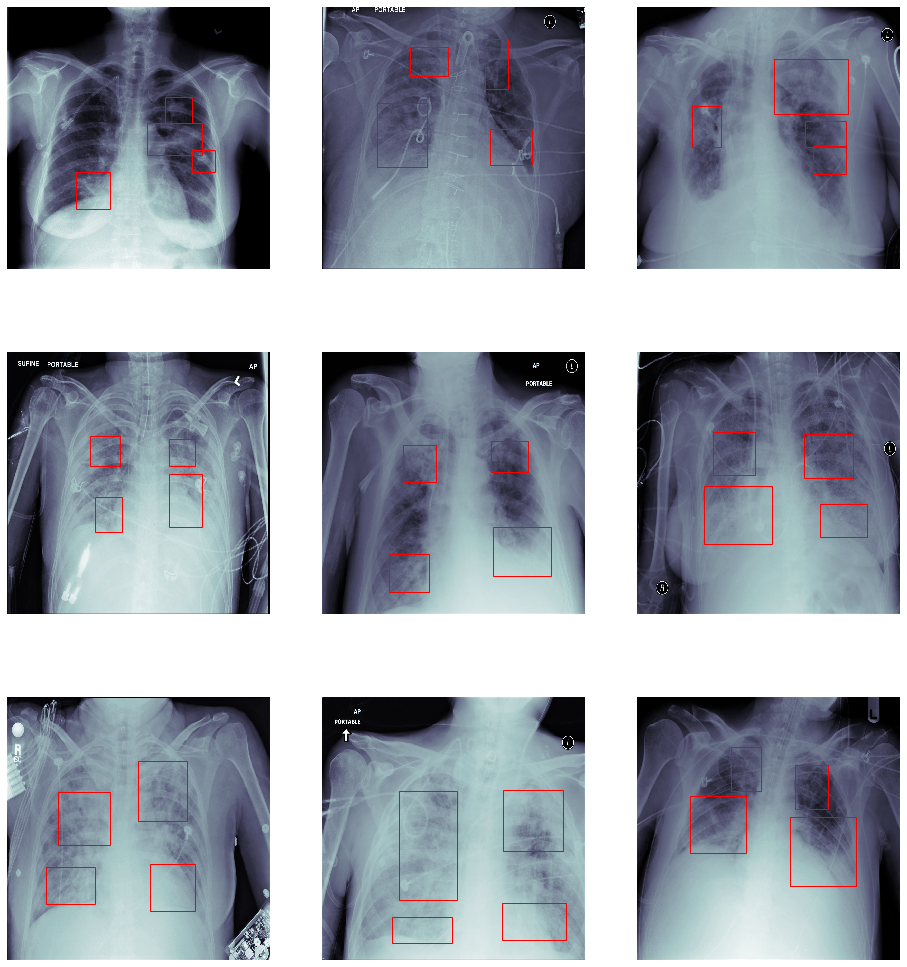

In [16]:
print_bounding_box(df_4.head(9))

26684 patients


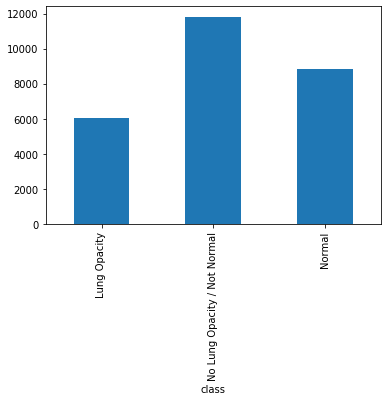

In [17]:
print(_df['patientId'].value_counts().shape[0], 'patients')
_df.groupby('class').size().plot.bar()

#### It clearly shows patients with lung opacity is our target

In [18]:
_df.groupby(["class", "Target"]).size()

class                         Target
Lung Opacity                  1          6012
No Lung Opacity / Not Normal  0         11821
Normal                        0          8851
dtype: int64